In [1]:
from typing import Collection, List
import os
from dataclasses import dataclass, field
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
from sklearn.cluster import KMeans

In [2]:
plt.style.use('seaborn')

In [3]:
%run common.ipynb

In [4]:
@dataclass
class Edge(object):
    entity: str
    relation: str

        
@dataclass
class Node(object):
    input_edges: List[Edge] = field(default_factory=list)
    output_edges: List[Edge] = field(default_factory=list)

        
class FingerprintFactory(object):
    
    def __init__(self, dataset_relations: Collection[str]):
        self.relations_indexes = dict(zip(
            dataset_relations, range(len(dataset_relations))
        ))

    def _get_fingerprint_of_edges(self, edges: List[Edge]):
        fingerprint = np.zeros(len(self.relations_indexes), dtype=np.float32)
        for edge in edges:
            relation_index = self.relations_indexes[edge.relation]
            fingerprint[relation_index] += 1.0
        return fingerprint / np.maximum(np.sum(fingerprint), 1.0)
    
    def get_input_fingerprint(self, node: Node):
        return self._get_fingerprint_of_edges(node.input_edges)
    
    def get_output_fingerprint(self, node: Node):
        return self._get_fingerprint_of_edges(node.output_edges)

In [5]:
def construct_graph(samples_path):
    samples = load_matching_samples(samples_path)
    graph = defaultdict(Node)
    for head_entity, relation, tail_entity in samples:
        output_edge = Edge(tail_entity, relation)
        graph[head_entity].output_edges.append(output_edge)
        input_edge = Edge(head_entity, relation)
        graph[tail_entity].input_edges.append(input_edge)
    return graph


def plot_relations_count_distribution(
    counts, bin_size, relations_count_threshold, title
):
    clipped_counts = [
        np.clip(value, 0, relations_count_threshold + 1)
        for value in counts
    ]
    bins = np.array([bin_size * i for i in range(12)])
    plt.figure(figsize=(12, 8))
    plt.title(title)
    plt.xlabel("Number of edges for a node")
    plt.ylabel("Nodes count")    
    plt.hist(clipped_counts, bins=bins, rwidth=0.9)    
    labels = [
        f"[{bins[i - 1]}-{bins[i]})" for i in range(1, len(bins) - 1)
    ]  
    labels.append(f"{bins[-2]}+")
    plt.xticks(bins[:-1] + bin_size / 2.0, labels)


def plot_relations_counts(graph, bin_size, relations_count_threshold):
    output_counts = [len(node.output_edges) for node in graph.values()]            
    plot_relations_count_distribution(
        output_counts,
        bin_size,
        relations_count_threshold,
        title="A distribution of output edges counts"
    )    
    input_counts = [len(node.input_edges) for node in graph.values()]    
    plot_relations_count_distribution(
        input_counts,
        bin_size,
        relations_count_threshold,        
        title="A distribution of input edges counts"
    )


def analyze_nodes_fingerprints(
    entity_fingerprints, clusters_count, bins_count, fingerprints_type
):
    fingerprints = list(entity_fingerprints.values())
    data_matrix = np.vstack(fingerprints)
    k_means = KMeans(n_clusters=clusters_count, max_iter=50000)
    cluster_indexes = k_means.fit_predict(data_matrix)
    samples_counts, filled_features_counts = [], []
    for cluster_index in sorted(set(cluster_indexes)):
        cluster_samples = data_matrix[cluster_indexes == cluster_index]
        filled_features_count = np.sum(np.any(cluster_samples > 1e-5, axis=0))
        samples_counts.append(len(cluster_samples))
        filled_features_counts.append(filled_features_count)
    plt.figure(figsize=(12, 8))
    plt.title(
        "The number of samples in clusters vs. the number of non-trivial "
        f"features for clusters ({fingerprints_type} edges, "
        f"{clusters_count} clusters)"
    )
    plt.xlabel("Samples count")
    plt.ylabel("The number of non-trivial features")
    plt.scatter(samples_counts, filled_features_counts)

    
def analyze_graph_fingerprints(
    dataset_path, graph, clusters_count, clusters_bins_count
):
    relations = load_relations_of_dataset(dataset_path)
    fingerprint_factory = FingerprintFactory(relations)
    output_fingerprints = {  
        entity_name: fingerprint_factory.get_output_fingerprint(node)
        for entity_name, node in graph.items()
    }
    analyze_nodes_fingerprints(
        output_fingerprints,
        clusters_count,
        clusters_bins_count,
        fingerprints_type="output",
    )    
    input_fingerprints = {
        entity_name: fingerprint_factory.get_input_fingerprint(node)
        for entity_name, node in graph.items()
    }
    analyze_nodes_fingerprints(
        input_fingerprints,
        clusters_count,
        clusters_bins_count,
        fingerprints_type="input",
    )


def explore_dataset_fingerprints(
    dataset_path,
    relations_bin_size,
    relations_count_threshold,
    clusters_count,
    clusters_bins_count,
):
    training_samples_path = get_training_samples_path(dataset_path)
    graph = construct_graph(training_samples_path)
    plot_relations_counts(
        graph, relations_bin_size, relations_count_threshold
    )
    analyze_graph_fingerprints(
        dataset_path, graph, clusters_count, clusters_bins_count
    )

## WN18RR

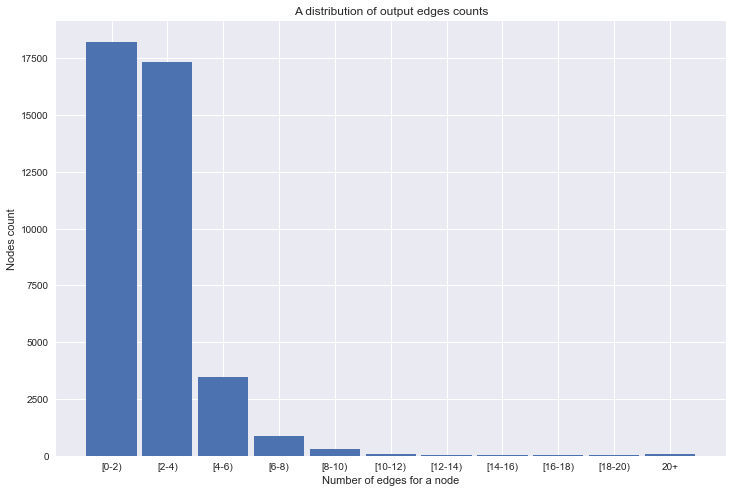

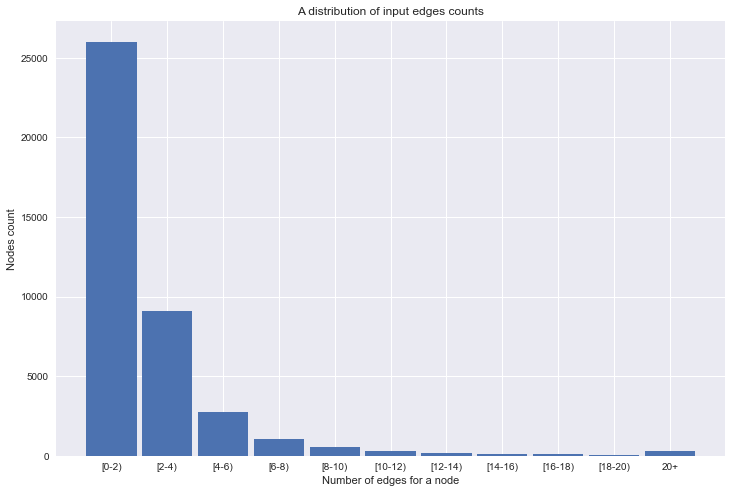

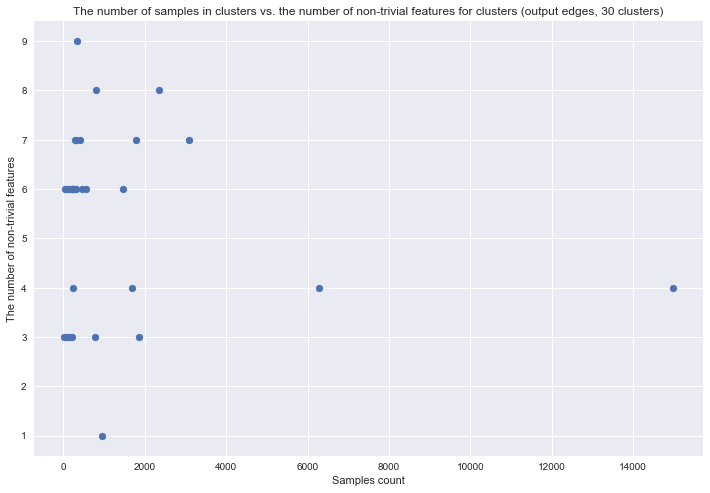

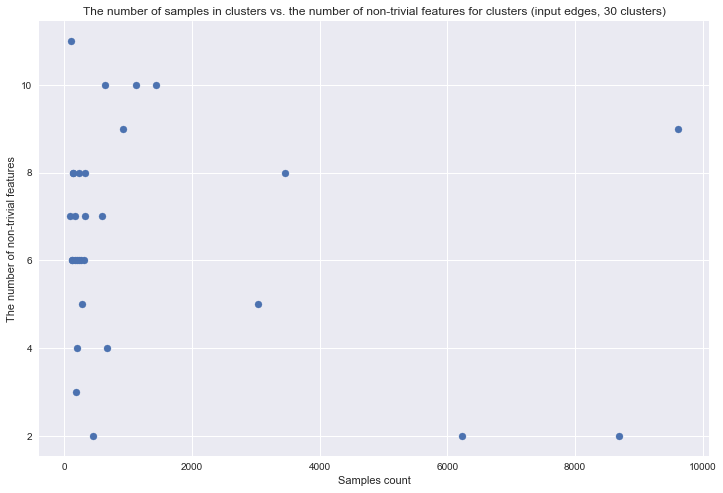

In [6]:
explore_dataset_fingerprints(
    WN18RR_DATASET_PATH,
    relations_bin_size=2,
    relations_count_threshold=21,
    clusters_count=30,
    clusters_bins_count=5,
)

## FB15K

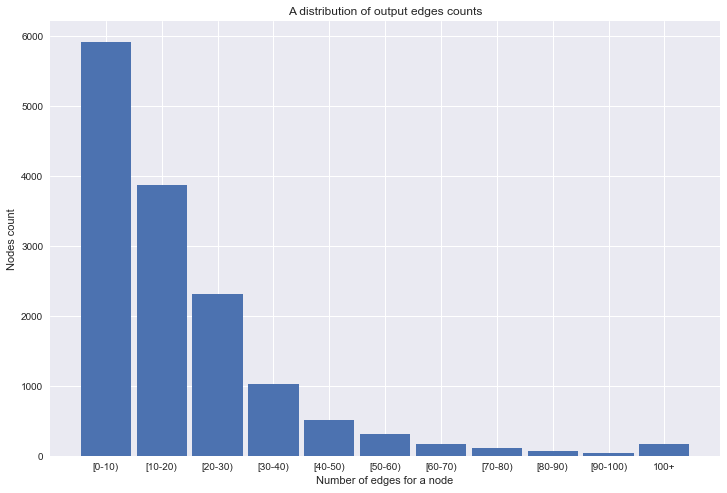

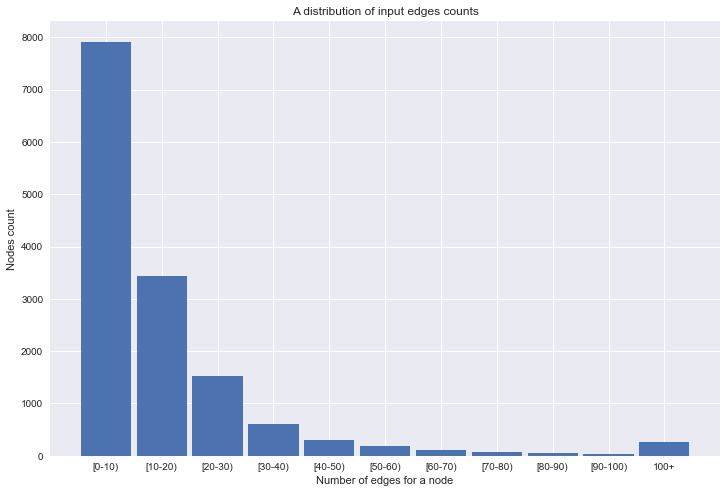

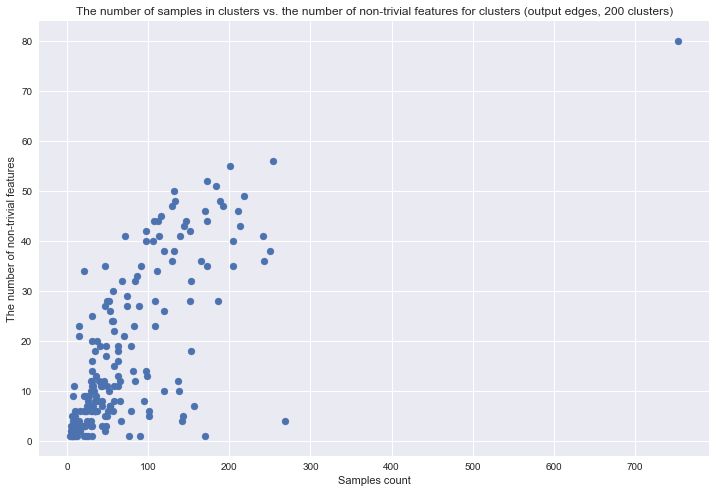

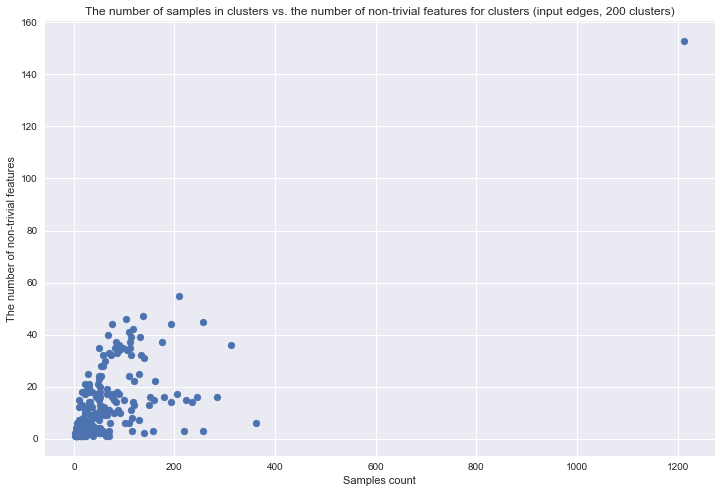

In [7]:
explore_dataset_fingerprints(
    FB15K_DATASET_PATH,
    relations_bin_size=10,
    relations_count_threshold=101,
    clusters_count=200,
    clusters_bins_count=30,
)